In [1]:
import yfinance as yf
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from finta import TA
import numpy as np
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import jaccard_score
import seaborn as sn
from tabulate import tabulate
import tensorflow as tf

In [2]:
WINDOW = 1 # number of rows to look ahead to see what the price did
FETCH_INTERVAL = "60m"  # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
INTERVAL = '2y'     # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
symbol = 'FB'      # Symbol of the desired stock
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'CCI', 'VORTEX']
ROWS_TO_PREDICT = 16

In [3]:
data = yf.download(  # or pdr.get_data_yahoo(...
        tickers = symbol,


        period = INTERVAL,

        interval = FETCH_INTERVAL,

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        # auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2019-02-05 04:00:00-05:00,168.970000,168.970000,168.510000,168.510000,168.510000,0
2019-02-05 05:00:00-05:00,168.500000,168.950000,168.500000,168.950000,168.950000,0
2019-02-05 06:00:00-05:00,168.950000,168.950000,168.620000,168.950000,168.950000,0
2019-02-05 07:00:00-05:00,168.980000,169.400000,168.980000,169.400000,169.400000,0
2019-02-05 08:00:00-05:00,169.390000,169.700000,168.979900,169.150000,169.150000,0
...,...,...,...,...,...,...
2021-02-04 15:30:00-05:00,265.684296,266.649994,265.387299,266.619995,266.619995,1684009
2021-02-04 16:00:00-05:00,266.630000,275.745000,265.620000,266.300000,266.300000,0
2021-02-04 17:00:00-05:00,266.330000,266.490000,252.051000,266.100000,266.100000,0


In [4]:
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
data.head(10)

,open,high,low,close,Adj Close,volume
Datetime,,,,,,
2019-02-05 04:00:00-05:00,168.970000,168.970000,168.510000,168.510000,168.510000,0
2019-02-05 05:00:00-05:00,168.500000,168.950000,168.500000,168.950000,168.950000,0
2019-02-05 06:00:00-05:00,168.950000,168.950000,168.620000,168.950000,168.950000,0
2019-02-05 07:00:00-05:00,168.980000,169.400000,168.980000,169.400000,169.400000,0
2019-02-05 08:00:00-05:00,169.390000,169.700000,168.979900,169.150000,169.150000,0
2019-02-05 09:00:00-05:00,169.150000,169.650000,169.120000,169.200000,169.200000,0
2019-02-05 09:30:00-05:00,169.029999,171.500000,168.690002,171.250000,171.250000,6369437
2019-02-05 10:30:00-05:00,171.300003,171.970001,170.649994,171.279999,171.279999,3312872
2019-02-05 11:30:00-05:00,171.262497,171.350006,169.869995,170.250000,170.250000,2152564


<AxesSubplot:xlabel='Datetime'>

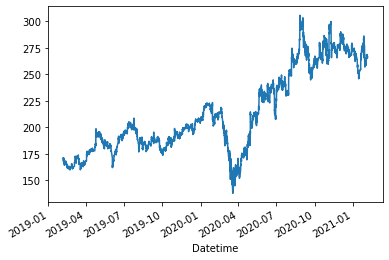

In [5]:
data['close'].plot()

In [6]:
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """
    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = pd.concat([data, ind_data], axis=1)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['close'] / data['close'].ewm(50).mean()
    data['ema21'] = data['close'] / data['close'].ewm(21).mean()
    data['ema15'] = data['close'] / data['close'].ewm(ROWS_TO_PREDICT).mean()
    data['ema5'] = data['close'] / data['close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()

    # Remove columns that won't be used as features
    del (data['open'])
    del (data['high'])
    del (data['low'])
    del (data['volume'])
    del (data['Adj Close'])

    return data

data = _get_indicator_data(data)

In [7]:
data

,close,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,20 period CCI,VIm,VIp,ema50,ema21,ema15,ema5,normVol
Datetime,,,,,,,,,,,,,,,,,,
2019-02-05 04:00:00-05:00,168.510000,NaN,0.000000,0.000000,NaN,-0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,NaN
2019-02-05 05:00:00-05:00,168.950000,100.000000,0.009872,0.005484,NaN,0.000000e+00,NaN,NaN,NaN,NaN,66.666667,NaN,NaN,1.001291,1.001273,1.001264,1.001185,NaN
2019-02-05 06:00:00-05:00,168.950000,100.000000,0.012579,0.008392,NaN,0.000000e+00,NaN,NaN,NaN,NaN,69.148936,NaN,NaN,1.000852,1.000829,1.000817,1.000716,NaN
2019-02-05 07:00:00-05:00,169.400000,100.000000,0.029749,0.015626,NaN,0.000000e+00,NaN,NaN,NaN,NaN,133.333333,NaN,NaN,1.002609,1.002557,1.002529,1.002290,NaN
2019-02-05 08:00:00-05:00,169.150000,75.493698,0.028504,0.019457,NaN,0.000000e+00,NaN,NaN,NaN,NaN,85.641031,NaN,NaN,1.000895,1.000841,1.000813,1.000585,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-04 15:30:00-05:00,266.619995,51.664033,-0.122250,0.027952,58.351784,8.538465e+09,1.342686,-0.230005,20.495267,-0.026250,-42.789801,1.026599,0.930167,0.999563,1.001644,1.001395,1.001725,1.204844
2021-02-04 16:00:00-05:00,266.300000,49.971431,-0.104504,0.001461,19.582801,8.538465e+09,2.030186,-0.900000,20.495267,-0.090043,230.294679,0.697600,0.963761,0.998396,1.000422,1.000182,1.000436,0.000000
2021-02-04 17:00:00-05:00,266.100000,48.893262,-0.105364,-0.019904,59.293492,8.538465e+09,3.014400,-2.000000,20.495267,-0.281057,-326.957706,1.019667,0.653828,0.997692,0.999685,0.999464,0.999737,0.000000


In [8]:
data.columns

Index(['close', '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
       '14 period ATR', 'MOM', '14 period MFI', 'ROC', '20 period CCI', 'VIm',
       'VIp', 'ema50', 'ema21', 'ema15', 'ema5', 'normVol'],
      dtype='object')

In [9]:
def create_class_column(row):
    if row['close_shift']-row['close'] > 0.35:
        return 1
    if row['close_shift'] -row['close']< -0.35:
        return 2
    else:
        return 0

In [10]:
data['close_shift'] = data.shift(-WINDOW)['close']
data

,close,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,20 period CCI,VIm,VIp,ema50,ema21,ema15,ema5,normVol,close_shift
Datetime,,,,,,,,,,,,,,,,,,,
2019-02-05 04:00:00-05:00,168.510000,NaN,0.000000,0.000000,NaN,-0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,NaN,168.95
2019-02-05 05:00:00-05:00,168.950000,100.000000,0.009872,0.005484,NaN,0.000000e+00,NaN,NaN,NaN,NaN,66.666667,NaN,NaN,1.001291,1.001273,1.001264,1.001185,NaN,168.95
2019-02-05 06:00:00-05:00,168.950000,100.000000,0.012579,0.008392,NaN,0.000000e+00,NaN,NaN,NaN,NaN,69.148936,NaN,NaN,1.000852,1.000829,1.000817,1.000716,NaN,169.40
2019-02-05 07:00:00-05:00,169.400000,100.000000,0.029749,0.015626,NaN,0.000000e+00,NaN,NaN,NaN,NaN,133.333333,NaN,NaN,1.002609,1.002557,1.002529,1.002290,NaN,169.15
2019-02-05 08:00:00-05:00,169.150000,75.493698,0.028504,0.019457,NaN,0.000000e+00,NaN,NaN,NaN,NaN,85.641031,NaN,NaN,1.000895,1.000841,1.000813,1.000585,NaN,169.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-04 15:30:00-05:00,266.619995,51.664033,-0.122250,0.027952,58.351784,8.538465e+09,1.342686,-0.230005,20.495267,-0.026250,-42.789801,1.026599,0.930167,0.999563,1.001644,1.001395,1.001725,1.204844,266.30
2021-02-04 16:00:00-05:00,266.300000,49.971431,-0.104504,0.001461,19.582801,8.538465e+09,2.030186,-0.900000,20.495267,-0.090043,230.294679,0.697600,0.963761,0.998396,1.000422,1.000182,1.000436,0.000000,266.10
2021-02-04 17:00:00-05:00,266.100000,48.893262,-0.105364,-0.019904,59.293492,8.538465e+09,3.014400,-2.000000,20.495267,-0.281057,-326.957706,1.019667,0.653828,0.997692,0.999685,0.999464,0.999737,0.000000,265.93


In [11]:
data['class_column'] = data.apply(create_class_column, axis=1)
data

,close,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,20 period CCI,VIm,VIp,ema50,ema21,ema15,ema5,normVol,close_shift,class_column
Datetime,,,,,,,,,,,,,,,,,,,,
2019-02-05 04:00:00-05:00,168.510000,NaN,0.000000,0.000000,NaN,-0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,NaN,168.95,1
2019-02-05 05:00:00-05:00,168.950000,100.000000,0.009872,0.005484,NaN,0.000000e+00,NaN,NaN,NaN,NaN,66.666667,NaN,NaN,1.001291,1.001273,1.001264,1.001185,NaN,168.95,0
2019-02-05 06:00:00-05:00,168.950000,100.000000,0.012579,0.008392,NaN,0.000000e+00,NaN,NaN,NaN,NaN,69.148936,NaN,NaN,1.000852,1.000829,1.000817,1.000716,NaN,169.40,1
2019-02-05 07:00:00-05:00,169.400000,100.000000,0.029749,0.015626,NaN,0.000000e+00,NaN,NaN,NaN,NaN,133.333333,NaN,NaN,1.002609,1.002557,1.002529,1.002290,NaN,169.15,0
2019-02-05 08:00:00-05:00,169.150000,75.493698,0.028504,0.019457,NaN,0.000000e+00,NaN,NaN,NaN,NaN,85.641031,NaN,NaN,1.000895,1.000841,1.000813,1.000585,NaN,169.20,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-04 15:30:00-05:00,266.619995,51.664033,-0.122250,0.027952,58.351784,8.538465e+09,1.342686,-0.230005,20.495267,-0.026250,-42.789801,1.026599,0.930167,0.999563,1.001644,1.001395,1.001725,1.204844,266.30,0
2021-02-04 16:00:00-05:00,266.300000,49.971431,-0.104504,0.001461,19.582801,8.538465e+09,2.030186,-0.900000,20.495267,-0.090043,230.294679,0.697600,0.963761,0.998396,1.000422,1.000182,1.000436,0.000000,266.10,0
2021-02-04 17:00:00-05:00,266.100000,48.893262,-0.105364,-0.019904,59.293492,8.538465e+09,3.014400,-2.000000,20.495267,-0.281057,-326.957706,1.019667,0.653828,0.997692,0.999685,0.999464,0.999737,0.000000,265.93,0


In [12]:
# Class divide
data['class_column'].value_counts()

0    3589
1    2293
2    2145
Name: class_column, dtype: int64

In [13]:
del (data['close'])
del (data['close_shift'])
data = data.dropna()
train_set = data.iloc[:-ROWS_TO_PREDICT]
test_set =data.iloc[-ROWS_TO_PREDICT:]

In [14]:
data['class_column'].value_counts()

0    3475
1    2245
2    2103
Name: class_column, dtype: int64

In [15]:
y = data['class_column']
features = [x for x in data.columns if x not in ['class_column']]
x = data[features]

x_train= x.iloc[:-ROWS_TO_PREDICT]
y_train= y.iloc[:-ROWS_TO_PREDICT]
x_test =x.iloc[-ROWS_TO_PREDICT:]
y_test=y.iloc[-ROWS_TO_PREDICT:]

In [16]:
classifiers = dict()

classifiers['DecisionTreeClassifier 1'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='gini',splitter='best')
classifiers['DecisionTreeClassifier 2'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='gini',splitter='random')
classifiers['DecisionTreeClassifier 3'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='entropy',splitter='best')
classifiers['DecisionTreeClassifier 4'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='entropy',splitter='random')
classifiers['DecisionTreeClassifier 5'] = DecisionTreeClassifier(random_state=0,criterion='gini',splitter='best')
classifiers['DecisionTreeClassifier 6'] = DecisionTreeClassifier(random_state=0,criterion='gini',splitter='random')
classifiers['DecisionTreeClassifier 7'] = DecisionTreeClassifier(random_state=0,criterion='entropy',splitter='best')
classifiers['DecisionTreeClassifier 8'] = DecisionTreeClassifier(random_state=0,criterion='entropy',splitter='random')

classifiers['RandomForestClassifier 1'] = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0,criterion='gini')
classifiers['RandomForestClassifier 2'] = RandomForestClassifier(n_estimators=1000, max_depth=2, random_state=0,criterion='gini')
classifiers['RandomForestClassifier 3'] = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0,criterion='gini')
classifiers['RandomForestClassifier 4'] = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=0,criterion='gini')
classifiers['RandomForestClassifier 5'] = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0,criterion='entropy')
classifiers['RandomForestClassifier 6'] = RandomForestClassifier(n_estimators=1000, max_depth=2, random_state=0,criterion='entropy')
classifiers['RandomForestClassifier 7'] = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0,criterion='entropy')
classifiers['RandomForestClassifier 8'] = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=0,criterion='entropy')

classifiers['GradientBoostingClassifier 1'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.1)
classifiers['GradientBoostingClassifier 2'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.3)
classifiers['GradientBoostingClassifier 3'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.5)
classifiers['GradientBoostingClassifier 4'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=1)
#
classifiers['GradientBoostingClassifier 5'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.1)
classifiers['GradientBoostingClassifier 6'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.3)
classifiers['GradientBoostingClassifier 7'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.5)
classifiers['GradientBoostingClassifier 8'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=1)

classifiers['GradientBoostingClassifier 9'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=0.1)
classifiers['GradientBoostingClassifier 10'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=0.3)
classifiers['GradientBoostingClassifier 11'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=0.5)
classifiers['GradientBoostingClassifier 12'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=1)

In [17]:
def print_conf_matrix(test_y, predict, name):
    matrix = confusion_matrix(test_y, predict,  labels=[-1, 0, 1])
    print(matrix)
    ax= plt.subplot()
    sn.heatmap(matrix, annot=True, ax = ax) #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels', color='white')
    ax.set_ylabel('True labels', color='white')
    ax.set_title(f'Confusion Matrix for {name}' , color='white')
    ax.xaxis.set_ticklabels(['-1','0', '1'], color='white')
    ax.yaxis.set_ticklabels(['-1','0', '1'], color='white')
    plt.show()

def train_model(model,train_x, train_y):
    model.fit(train_x, train_y)

In [18]:
# predictions= dict()
# score = dict()
# for k,v in classifiers.items():
#     print("Calculate: ", k)
#     train_model(v,x_train,y_train)
#     predictions[k] = v.predict(x_test)
#     score[k] = accuracy_score(y_test.values, predictions[k])
#     print('Score: ',  score[k] )
#     # print_conf_matrix(test_y, predictions[k], k)
#
# headers = ["Classifier type", "Accuracy"]
# score_df = pd.DataFrame(score.items(), columns=headers)
# print(tabulate(score_df, headers, tablefmt="psql"))

In [19]:
# estimators=[
#             ('GBC12', classifiers['GradientBoostingClassifier 12']),
#             ('DTC1', classifiers['DecisionTreeClassifier 1']),
#             ]
# ensemble = VotingClassifier(estimators, voting='soft')
# ensemble.fit(x_train, y_train)
# predicted = ensemble.predict(x_test)
# score_ensemble = accuracy_score(y_test.values, predicted)
# print('Score: ',  score_ensemble)

In [20]:
# print('Score: ',  score_ensemble)

In [21]:
feature_columns = []
for feature_name in x_train.columns:
  feature_columns.append(tf.feature_column.numeric_column(feature_name,
                                                          dtype=tf.float32))
feature_columns

[NumericColumn(key='14 period RSI', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='MACD', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='SIGNAL', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='14 period STOCH %K', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='MFV', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='14 period ATR', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='MOM', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='14 period MFI', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='ROC', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='20 period CCI', shape=(1,), default_value=None, dtype=tf.f

In [22]:
NUM_EXAMPLES = len(y_train)
print(NUM_EXAMPLES)

7807


In [23]:
def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).
    dataset = dataset.repeat(n_epochs)
    # In memory training doesn't use batching.
    dataset = dataset.batch(NUM_EXAMPLES)
    return dataset
  return input_fn

In [24]:
train_input_fn = make_input_fn(x_train, y_train)
eval_input_fn = make_input_fn(x_test, y_test, shuffle=False, n_epochs=1)


In [25]:
est = tf.estimator.BoostedTreesClassifier(
    feature_columns, 1, model_dir=None, n_classes=3,
    weight_column=None, label_vocabulary=None, n_trees=500, max_depth=6,
    learning_rate=0.5, l1_regularization=0.0, l2_regularization=0.0,
    tree_complexity=0.0, min_node_weight=0.0, config=None, center_bias=False,
    pruning_mode='none', quantile_sketch_epsilon=0.01,
    train_in_memory=False
)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\exomat\\AppData\\Local\\Temp\\tmpwsenucsr', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [26]:
est.train(train_input_fn, max_steps=2000)
result = est.evaluate(eval_input_fn)
result

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\exomat\AppData\Local\Temp\tmpwsenucsr\model.ckpt.
Type is unsupported, or the types of the items don't match field t

{'accuracy': 0.25,
 'average_loss': 34.538776,
 'loss': 34.538776,
 'global_step': 2000}